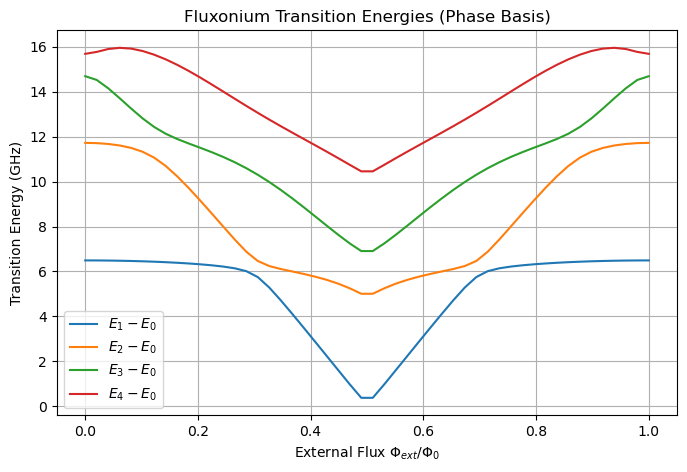

In [1]:
# Implementing the fluxonium Hamiltonian in the phase basis (finite-difference method):
# H = -4EC d²/dphi² - EJ cos(phi - phi_ext) + (1/2) EL phi²
## Step 1: Import Libraries
import numpy as np
from scipy.sparse import diags
from scipy.linalg import expm
import matplotlib.pyplot as plt



def build_fluxonium_phase_basis(EC, EJ, EL, N=5, phi_min=-6*np.pi, phi_max=6*np.pi, num_pts=200, phi_ext=0.0):
    """
    Constructs the fluxonium Hamiltonian in the phase basis using finite differences.

    Parameters:
    - EC, EJ, EL: energies (GHz)
    - N: number of levels to return
    - phi_min, phi_max: range of phase grid
    - num_pts: number of grid points
    - phi_ext: external flux in units of Phi_0

    Returns:
    - evals: first N eigenenergies
    """
    # Grid
    phi = np.linspace(phi_min, phi_max, num_pts)
    dphi = phi[1] - phi[0]
    dim = len(phi)

    # Second derivative operator (finite difference for kinetic term)
    kinetic = (-2 * np.eye(dim) + np.eye(dim, k=1) + np.eye(dim, k=-1)) / dphi**2
    T = -4 * EC * kinetic

    # Potential energy: cosine + quadratic
    V = -EJ * np.cos(phi - 2 * np.pi * phi_ext) + 0.5 * EL * phi**2
    V_matrix = np.diag(V)

    H = T + V_matrix
    evals, _ = np.linalg.eigh(H)
    return evals[:N]

# Sweep phi_ext from 0 to 1 and collect spectrum
phi_ext_list = np.linspace(0, 1, 50)
EC, EJ, EL, N = 1.0, 6.0, 1.0, 5
all_levels_phase = []

for phi_ext in phi_ext_list:
    levels = build_fluxonium_phase_basis(EC, EJ, EL, N, phi_ext=phi_ext)
    all_levels_phase.append(levels)

all_levels_phase = np.array(all_levels_phase)
transition_energies_phase = all_levels_phase - all_levels_phase[:, [0]]

# Plot transition energies from phase basis
plt.figure(figsize=(8, 5))
for i in range(1, N):
    plt.plot(phi_ext_list, transition_energies_phase[:, i], label=f"$E_{i} - E_0$")

plt.xlabel("External Flux $\Phi_{ext} / \Phi_0$")
plt.ylabel("Transition Energy (GHz)")
plt.title("Fluxonium Transition Energies (Phase Basis)")
plt.grid(True)
plt.legend()
plt.show()


In [2]:
import numpy as np
from scipy.linalg import eigh

def get_fluxonium_wavefunctions(EC, EJ, EL, phi_ext, N=5, phi_min=-6*np.pi, phi_max=6*np.pi, num_pts=200):
    """
    Compute eigenenergies and wavefunctions of fluxonium in phase basis.

    Parameters:
    - EC, EJ, EL: charging energy, Josephson energy, inductive energy (in GHz)
    - phi_ext: external flux in units of Phi_0
    - N: number of eigenstates to return
    - phi_min, phi_max: phase space range (in radians)
    - num_pts: number of discretization points

    Returns:
    - phi_vals: array of phase values
    - evals: first N eigenenergies
    - evecs: corresponding eigenfunctions, shape (num_pts, N)
    """
    # Phase grid
    phi_vals = np.linspace(phi_min, phi_max, num_pts)
    dphi = phi_vals[1] - phi_vals[0]

    # Kinetic energy (second derivative operator)
    T = -4 * EC * (
        -2 * np.eye(num_pts) +
        np.eye(num_pts, k=1) +
        np.eye(num_pts, k=-1)
    ) / dphi**2

    # Potential energy: shifted cosine + quadratic inductive term
    V = -EJ * np.cos(phi_vals - 2 * np.pi * phi_ext) + 0.5 * EL * phi_vals**2
    V_matrix = np.diag(V)

    # Total Hamiltonian
    H = T + V_matrix

    # Solve
    evals, evecs = eigh(H)
    return phi_vals, evals[:N], evecs[:, :N]


In [3]:
phi_vals, energies, wavefuncs = get_fluxonium_wavefunctions(EC=1.0, EJ=6.0, EL=1.0, phi_ext=0.5)


In [4]:
import numpy as np

def compute_matrix_elements(phi_vals, wavefuncs):
    """
    Compute matrix elements <i|phi|j> and <i|n|j> in the phase basis.

    Parameters:
    - phi_vals: 1D array of phase grid points
    - wavefuncs: 2D array of shape (len(phi_vals), N) with N wavefunctions

    Returns:
    - matrix_phi: <i|phi|j> matrix (NxN)
    - matrix_n: <i|n|j> matrix (NxN)
    """
    dphi = phi_vals[1] - phi_vals[0]
    dim = len(phi_vals)
    N = wavefuncs.shape[1]

    # Phase operator is diagonal
    phi_op = np.diag(phi_vals)

    # Hermitian central-difference derivative for charge operator
    off_diag = np.ones(dim - 1)
    deriv_matrix = (
        np.diag(-off_diag, -1) +
        np.diag(off_diag, 1)
    ) / (2 * dphi)
    n_op = -1j * deriv_matrix

    # Project to eigenbasis
    matrix_phi = wavefuncs.T @ phi_op @ wavefuncs
    matrix_n = wavefuncs.T @ n_op @ wavefuncs

    return matrix_phi, matrix_n


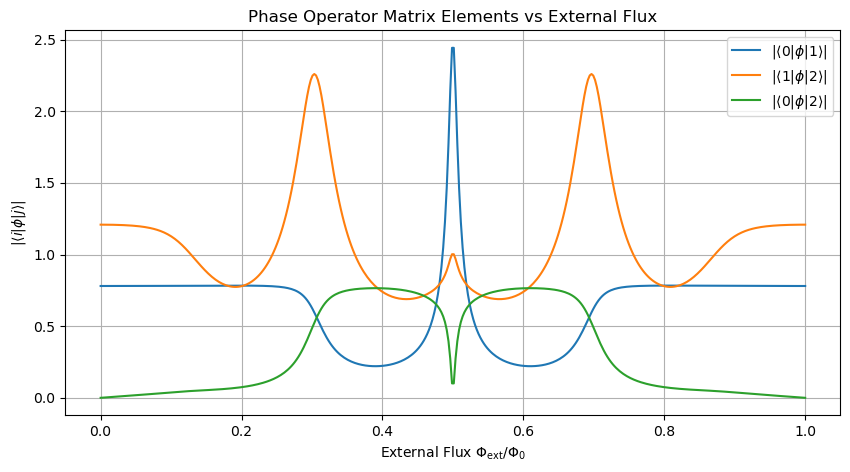

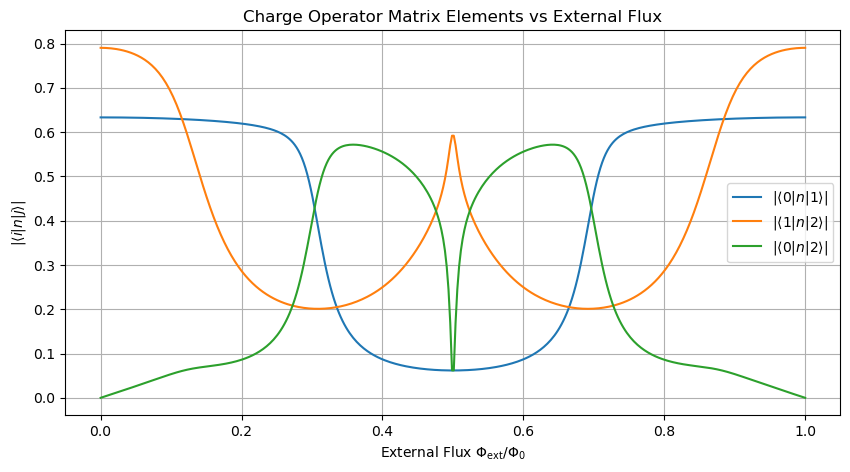

In [5]:
# Fixing the missing argument: compute dphi and pass it in

# Prepare storage
phi_ext_sweep = np.linspace(0, 1, 400)
phi_01_vals, phi_12_vals, phi_02_vals = [], [], []
n_01_vals, n_12_vals, n_02_vals = [], [], []

# Sweep phi_ext and compute matrix elements
for phi_ext in phi_ext_sweep:
    phi_vals, energies, wavefuncs = get_fluxonium_wavefunctions(EC, EJ, EL, phi_ext=phi_ext, N=5)
    dphi = phi_vals[1] - phi_vals[0]
    matrix_phi, matrix_n = compute_matrix_elements(phi_vals, wavefuncs)

    phi_01_vals.append(np.abs(matrix_phi[0, 1]))
    phi_12_vals.append(np.abs(matrix_phi[1, 2]))
    phi_02_vals.append(np.abs(matrix_phi[0, 2]))

    n_01_vals.append(np.abs(matrix_n[0, 1]))
    n_12_vals.append(np.abs(matrix_n[1, 2]))
    n_02_vals.append(np.abs(matrix_n[0, 2]))

# Plot |<i|phi|j>|
plt.figure(figsize=(10, 5))
plt.plot(phi_ext_sweep, phi_01_vals, label=r"$|\langle 0 | \phi | 1 \rangle|$")
plt.plot(phi_ext_sweep, phi_12_vals, label=r"$|\langle 1 | \phi | 2 \rangle|$")
plt.plot(phi_ext_sweep, phi_02_vals, label=r"$|\langle 0 | \phi | 2 \rangle|$")
plt.xlabel(r"External Flux $\Phi_{\rm ext}/\Phi_0$")
plt.ylabel(r"$|\langle i | \phi | j \rangle|$")
plt.title("Phase Operator Matrix Elements vs External Flux")
plt.legend()
plt.grid(True)
plt.show()

# Plot |<i|n|j>|
plt.figure(figsize=(10, 5))
plt.plot(phi_ext_sweep, n_01_vals, label=r"$|\langle 0 | n | 1 \rangle|$")
plt.plot(phi_ext_sweep, n_12_vals, label=r"$|\langle 1 | n | 2 \rangle|$")
plt.plot(phi_ext_sweep, n_02_vals, label=r"$|\langle 0 | n | 2 \rangle|$")
plt.xlabel(r"External Flux $\Phi_{\rm ext}/\Phi_0$")
plt.ylabel(r"$|\langle i | n | j \rangle|$")
plt.title("Charge Operator Matrix Elements vs External Flux")
plt.legend()
plt.grid(True)
plt.show()


## Now try the other hamiltonian

In [14]:
def get_fluxonium_wavefunctions_shifted_EL(EC, EJ, EL, phi_ext, N=10, phi_min=-6*np.pi, phi_max=6*np.pi, num_pts=200):
    phi_vals = np.linspace(phi_min, phi_max, num_pts)
    dphi = phi_vals[1] - phi_vals[0]

    T = -4 * EC * (
        -2 * np.eye(num_pts) +
        np.eye(num_pts, k=1) +
        np.eye(num_pts, k=-1)
    ) / dphi**2

    V = -EJ * np.cos(phi_vals) + 0.5 * EL * (phi_vals - 2 * np.pi * phi_ext)**2
    H = T + np.diag(V)

    evals, evecs = eigh(H)
    return phi_vals, evals[:N], evecs[:, :N]


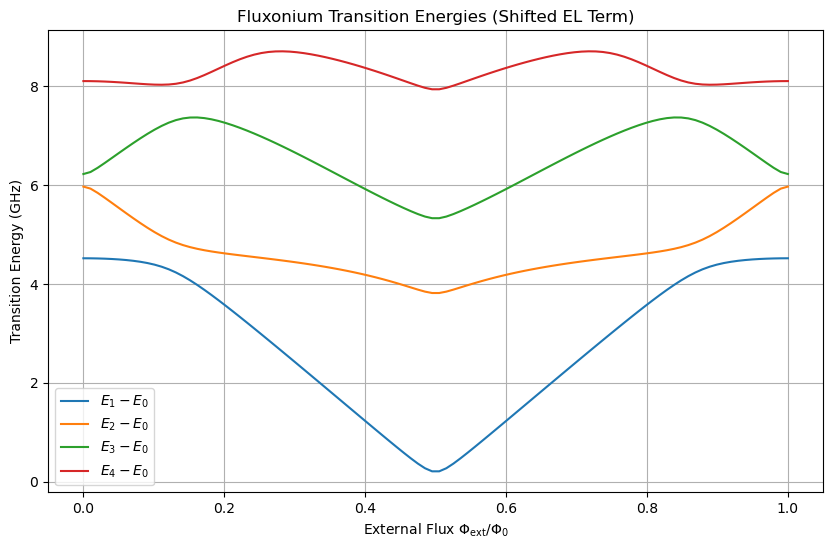

In [17]:
# Sweep flux_ext and compute eigenenergies using shifted EL term
phi_ext_vals = np.linspace(0, 1, 100)
energies_all = []

for phi_ext in phi_ext_vals:
    _, energies, _ = get_fluxonium_wavefunctions_shifted_EL(EC=1.0, EJ=3.730, EL=.360, phi_ext=phi_ext, N=5)
    energies_all.append(energies)

energies_all = np.array(energies_all)
E0 = energies_all[:, 0]

# Compute transitions: Ei - E0
transitions = energies_all - E0[:, None]

# Plot
plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for i in range(1, 5):
    plt.plot(phi_ext_vals, transitions[:, i], label=fr"$E_{i} - E_0$", color=colors[i-1])

plt.xlabel(r"External Flux $\Phi_{\rm ext}/\Phi_0$")
plt.ylabel("Transition Energy (GHz)")
plt.title("Fluxonium Transition Energies (Shifted EL Term)")
plt.grid(True)
plt.legend()
plt.show()


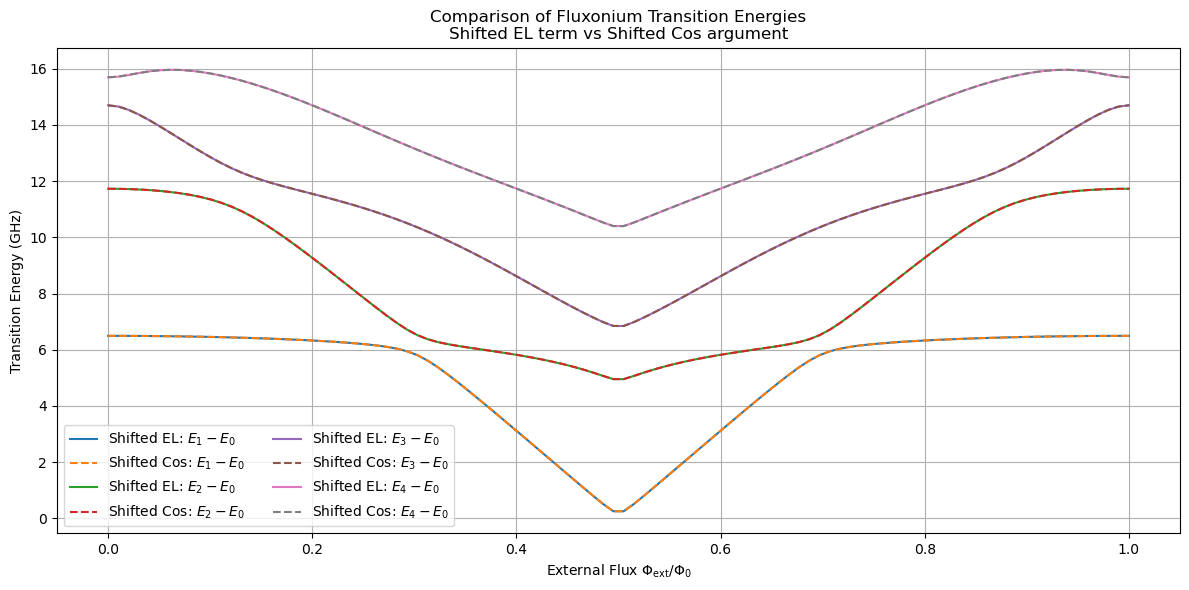

In [18]:
# Re-import after code execution environment reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Define both Hamiltonians again

def get_fluxonium_wavefunctions_shifted_EL(EC, EJ, EL, phi_ext, N=10, phi_min=-6*np.pi, phi_max=6*np.pi, num_pts=200):
    phi_vals = np.linspace(phi_min, phi_max, num_pts)
    dphi = phi_vals[1] - phi_vals[0]

    T = -4 * EC * (
        -2 * np.eye(num_pts) +
        np.eye(num_pts, k=1) +
        np.eye(num_pts, k=-1)
    ) / dphi**2

    V = -EJ * np.cos(phi_vals) + 0.5 * EL * (phi_vals - 2 * np.pi * phi_ext)**2
    H = T + np.diag(V)

    evals, evecs = eigh(H)
    return phi_vals, evals[:N], evecs[:, :N]

def build_fluxonium_phase_basis(EC, EJ, EL, N=5, phi_min=-6*np.pi, phi_max=6*np.pi, num_pts=200, phi_ext=0.0):
    phi = np.linspace(phi_min, phi_max, num_pts)
    dphi = phi[1] - phi[0]
    dim = len(phi)

    kinetic = (-2 * np.eye(dim) + np.eye(dim, k=1) + np.eye(dim, k=-1)) / dphi**2
    T = -4 * EC * kinetic

    V = -EJ * np.cos(phi - 2 * np.pi * phi_ext) + 0.5 * EL * phi**2
    V_matrix = np.diag(V)

    H = T + V_matrix
    evals, _ = eigh(H)
    return evals[:N]

# Now run comparison again
phi_ext_vals = np.linspace(0, 1, 100)
N_levels = 5

energies_shifted_EL = []
energies_cos_shifted = []

for phi_ext in phi_ext_vals:
    _, evals_shifted, _ = get_fluxonium_wavefunctions_shifted_EL(EC=1.0, EJ=6.0, EL=1.0, phi_ext=phi_ext, N=N_levels)
    evals_cos_shifted = build_fluxonium_phase_basis(EC=1.0, EJ=6.0, EL=1.0, N=N_levels, phi_ext=phi_ext)
    
    energies_shifted_EL.append(evals_shifted)
    energies_cos_shifted.append(evals_cos_shifted)

energies_shifted_EL = np.array(energies_shifted_EL)
energies_cos_shifted = np.array(energies_cos_shifted)

# Subtract ground state
E0_shifted = energies_shifted_EL[:, 0]
E0_cos = energies_cos_shifted[:, 0]
trans_shifted = energies_shifted_EL - E0_shifted[:, None]
trans_cos = energies_cos_shifted - E0_cos[:, None]

# Plot comparison
plt.figure(figsize=(12, 6))
for i in range(1, N_levels):
    plt.plot(phi_ext_vals, trans_shifted[:, i], label=fr"Shifted EL: $E_{i} - E_0$", linestyle='-')
    plt.plot(phi_ext_vals, trans_cos[:, i], label=fr"Shifted Cos: $E_{i} - E_0$", linestyle='--')

plt.xlabel(r"External Flux $\Phi_{\rm ext}/\Phi_0$")
plt.ylabel("Transition Energy (GHz)")
plt.title("Comparison of Fluxonium Transition Energies\nShifted EL term vs Shifted Cos argument")
plt.grid(True)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


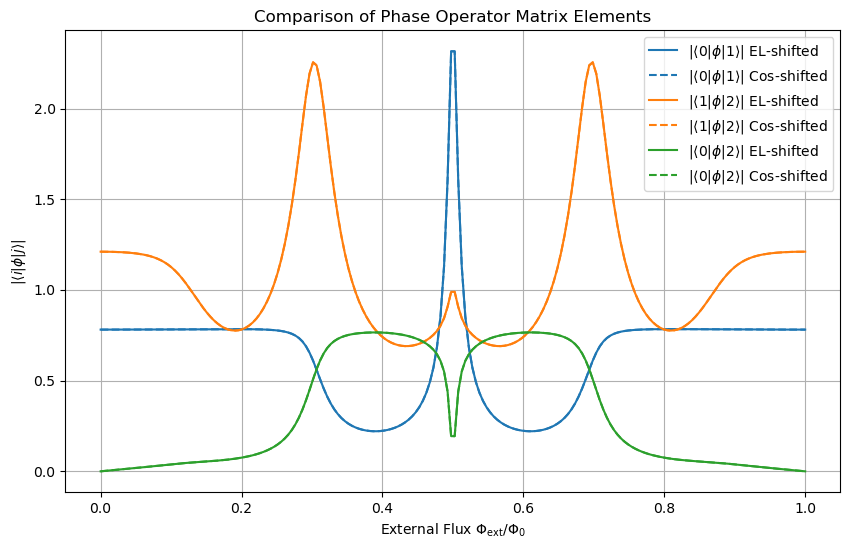

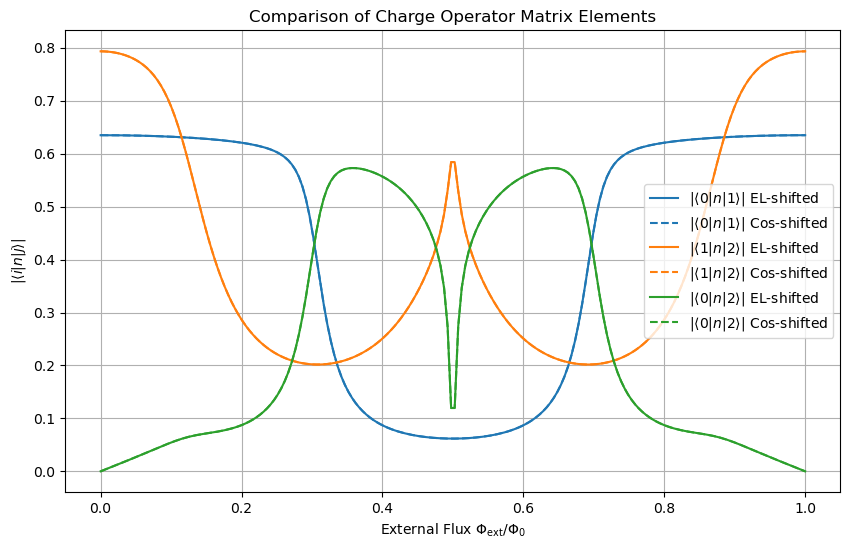

In [20]:
# Define the second Hamiltonian where the cosine term is shifted and EL is on phi^2
def get_fluxonium_wavefunctions_shifted_cos(EC, EJ, EL, phi_ext, N=5, phi_min=-6*np.pi, phi_max=6*np.pi, num_pts=300):
    phi_vals = np.linspace(phi_min, phi_max, num_pts)
    dphi = phi_vals[1] - phi_vals[0]

    T = -4 * EC * (
        -2 * np.eye(num_pts) +
        np.eye(num_pts, k=1) +
        np.eye(num_pts, k=-1)
    ) / dphi**2

    V = -EJ * np.cos(phi_vals - 2 * np.pi * phi_ext) + 0.5 * EL * phi_vals**2
    H = T + np.diag(V)

    evals, evecs = eigh(H)
    return phi_vals, evals[:N], evecs[:, :N]

# Storage for second Hamiltonian
phi_01_vals_cos, phi_12_vals_cos, phi_02_vals_cos = [], [], []
n_01_vals_cos, n_12_vals_cos, n_02_vals_cos = [], [], []

# Sweep phi_ext for cosine-shifted Hamiltonian
for phi_ext in phi_ext_sweep:
    phi_vals_cos, energies_cos, wavefuncs_cos = get_fluxonium_wavefunctions_shifted_cos(EC, EJ, EL, phi_ext=phi_ext, N=5)
    matrix_phi_cos, matrix_n_cos = compute_matrix_elements(phi_vals_cos, wavefuncs_cos)

    phi_01_vals_cos.append(np.abs(matrix_phi_cos[0, 1]))
    phi_12_vals_cos.append(np.abs(matrix_phi_cos[1, 2]))
    phi_02_vals_cos.append(np.abs(matrix_phi_cos[0, 2]))

    n_01_vals_cos.append(np.abs(matrix_n_cos[0, 1]))
    n_12_vals_cos.append(np.abs(matrix_n_cos[1, 2]))
    n_02_vals_cos.append(np.abs(matrix_n_cos[0, 2]))

import matplotlib.pyplot as plt

# Plot phase operator matrix elements comparison
plt.figure(figsize=(10, 6))
plt.plot(phi_ext_sweep, phi_01_vals, label=r"$|\langle 0|\phi|1\rangle|$ EL-shifted", color='C0', linestyle='-')
plt.plot(phi_ext_sweep, phi_01_vals_cos, label=r"$|\langle 0|\phi|1\rangle|$ Cos-shifted", color='C0', linestyle='--')
plt.plot(phi_ext_sweep, phi_12_vals, label=r"$|\langle 1|\phi|2\rangle|$ EL-shifted", color='C1', linestyle='-')
plt.plot(phi_ext_sweep, phi_12_vals_cos, label=r"$|\langle 1|\phi|2\rangle|$ Cos-shifted", color='C1', linestyle='--')
plt.plot(phi_ext_sweep, phi_02_vals, label=r"$|\langle 0|\phi|2\rangle|$ EL-shifted", color='C2', linestyle='-')
plt.plot(phi_ext_sweep, phi_02_vals_cos, label=r"$|\langle 0|\phi|2\rangle|$ Cos-shifted", color='C2', linestyle='--')
plt.xlabel(r"External Flux $\Phi_{\rm ext}/\Phi_0$")
plt.ylabel(r"$|\langle i | \phi | j \rangle|$")
plt.title("Comparison of Phase Operator Matrix Elements")
plt.legend()
plt.grid(True)
plt.show()

# Plot charge operator matrix elements comparison
plt.figure(figsize=(10, 6))
plt.plot(phi_ext_sweep, n_01_vals, label=r"$|\langle 0|n|1\rangle|$ EL-shifted", color='C0', linestyle='-')
plt.plot(phi_ext_sweep, n_01_vals_cos, label=r"$|\langle 0|n|1\rangle|$ Cos-shifted", color='C0', linestyle='--')
plt.plot(phi_ext_sweep, n_12_vals, label=r"$|\langle 1|n|2\rangle|$ EL-shifted", color='C1', linestyle='-')
plt.plot(phi_ext_sweep, n_12_vals_cos, label=r"$|\langle 1|n|2\rangle|$ Cos-shifted", color='C1', linestyle='--')
plt.plot(phi_ext_sweep, n_02_vals, label=r"$|\langle 0|n|2\rangle|$ EL-shifted", color='C2', linestyle='-')
plt.plot(phi_ext_sweep, n_02_vals_cos, label=r"$|\langle 0|n|2\rangle|$ Cos-shifted", color='C2', linestyle='--')
plt.xlabel(r"External Flux $\Phi_{\rm ext}/\Phi_0$")
plt.ylabel(r"$|\langle i | n | j \rangle|$")
plt.title("Comparison of Charge Operator Matrix Elements")
plt.legend()
plt.grid(True)
plt.show()


### Conclusion is both hamiltonains give identical energy levels and matrix elements with varying phi_ext

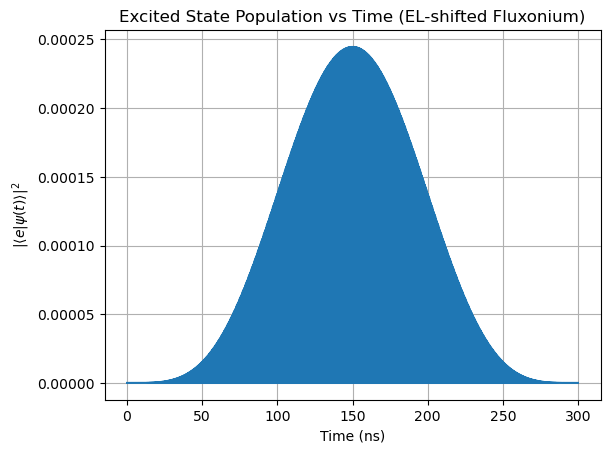

In [24]:
import numpy as np
from scipy.linalg import expm
from scipy.linalg import eigh

# Step 1: Setup constants
EC = 1.0
EJ = 6.0
EL = 1.0
phi_ext_dc = 0.5  # static DC bias
phi_amp = 0.02  # amplitude of drive in units of Phi0
omega_d = 6.0  # drive frequency in GHz
t_pulse = 300  # total duration in ns
dt = 0.1  # time step in ns
num_pts = 300
phi_min, phi_max = -6 * np.pi, 6 * np.pi
phi_vals = np.linspace(phi_min, phi_max, num_pts)
dphi = phi_vals[1] - phi_vals[0]

# Step 2: Define operators
T = -4 * EC * (
    -2 * np.eye(num_pts) +
    np.eye(num_pts, k=1) +
    np.eye(num_pts, k=-1)
) / dphi**2
phi_op = np.diag(phi_vals)

# Static eigenbasis
V_static = -EJ * np.cos(phi_vals) + 0.5 * EL * (phi_vals - 2 * np.pi * phi_ext_dc)**2
H_static = T + np.diag(V_static)
evals, evecs = eigh(H_static)
psi_0 = evecs[:, 0]

# Step 3: Drive envelope
def envelope(t, t_pulse):
    return np.sin(np.pi * t / t_pulse)**2 if 0 <= t <= t_pulse else 0.0

def phi_drive(t, phi_amp, omega_d, t_pulse):
    return 2 * np.pi * phi_amp * envelope(t, t_pulse) * np.cos(2 * np.pi * omega_d * t)

# Step 4: Time evolution
times = np.arange(0, t_pulse, dt)
psi_t = psi_0.copy()
probs = []

for t in times:
    phi_t = phi_drive(t, phi_amp, omega_d, t_pulse)
    V_t = -EJ * np.cos(phi_vals) + 0.5 * EL * (phi_vals - 2 * np.pi * phi_ext_dc - phi_t)**2
    H_t = T + np.diag(V_t)
    U = expm(-1j * H_t * dt)
    psi_t = U @ psi_t
    psi_t /= np.linalg.norm(psi_t)
    probs.append(np.abs(np.vdot(evecs[:, 1], psi_t))**2)  # excited state population

import matplotlib.pyplot as plt

plt.plot(times, probs)
plt.xlabel("Time (ns)")
plt.ylabel(r"$|\langle e|\psi(t)\rangle|^2$")
plt.title("Excited State Population vs Time (EL-shifted Fluxonium)")
plt.grid(True)
plt.show()


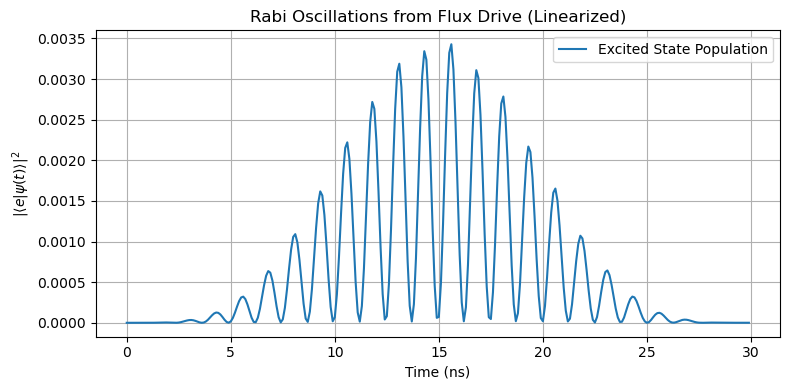

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, expm

# --- Parameters ---
EC = 1.0    # Charging energy
EJ = 6.0    # Josephson energy
EL = 1.0    # Inductive energy
phi_ext_dc = 0.5  # Static flux bias in units of Phi_0
phi_amp = 0.01    # Drive amplitude (small for linearized approximation)
omega_d = 0.4     # Drive frequency (GHz)
t_pulse = 30      # Total pulse duration (ns)
dt = 0.1          # Time step (ns)
times = np.arange(0, t_pulse, dt)

# --- Discretize phase space ---
num_pts = 200
phi_min, phi_max = -50 * np.pi, 50 * np.pi
phi_vals = np.linspace(phi_min, phi_max, num_pts)
dphi = phi_vals[1] - phi_vals[0]

# --- Operators ---
# Kinetic energy operator (finite difference second derivative)
T = -4 * EC * (
    -2 * np.eye(num_pts) +
    np.eye(num_pts, k=1) +
    np.eye(num_pts, k=-1)
) / dphi**2

# Potential energy (static)
V_static = -EJ * np.cos(phi_vals) + 0.5 * EL * (phi_vals - 2 * np.pi * phi_ext_dc)**2
phi_op = np.diag(phi_vals)  # phase operator

# Static Hamiltonian
H0 = T + np.diag(V_static)

# Eigenbasis
evals, evecs = eigh(H0)
psi_0 = evecs[:, 0]  # ground state
excited = evecs[:, 1]  # first excited state

# --- Time evolution with linearized flux drive ---
def phi_drive(t, phi_amp, omega_d, envelope_fn):
    return 2 * np.pi * phi_amp * envelope_fn(t) * np.cos(2 * np.pi * omega_d * t)

def envelope(t):
    return np.sin(np.pi * t / t_pulse)**2 if 0 <= t <= t_pulse else 0

psi_t = psi_0.copy()
pop_e = []

for t in times:
    drive_t = phi_drive(t, phi_amp, omega_d, envelope)
    H_t = H0 - EL * drive_t * phi_op  # Linearized drive term
    U = expm(-1j * H_t * dt)
    psi_t = U @ psi_t
    psi_t /= np.linalg.norm(psi_t)
    pop_e.append(np.abs(np.vdot(excited, psi_t))**2)

# --- Plot result ---
plt.figure(figsize=(8, 4))
plt.plot(times, pop_e, label="Excited State Population")
plt.xlabel("Time (ns)")
plt.ylabel(r"$|\langle e|\psi(t)\rangle|^2$")
plt.title("Rabi Oscillations from Flux Drive (Linearized)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Resonant g↔e frequency: 0.1675 GHz


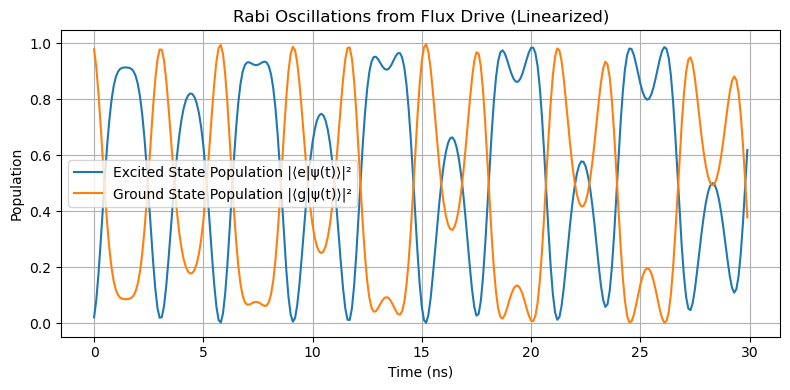

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, expm

# --- Parameters ---
EC = 1.0    # Charging energy
EJ = 6.0    # Josephson energy
EL = 1.0    # Inductive energy
phi_ext_dc = 0.5  # Static flux bias in units of Phi_0
phi_amp = 0.1   # Drive amplitude
# omega_d = 0.4     # Drive frequency (GHz)
t_pulse = 30      # Total pulse duration (ns)
dt = 0.1          # Time step (ns)
times = np.arange(0, t_pulse, dt)

# --- Discretize phase space ---
num_pts = 200
phi_min, phi_max = -50 * np.pi, 50 * np.pi
phi_vals = np.linspace(phi_min, phi_max, num_pts)
dphi = phi_vals[1] - phi_vals[0]

# --- Operators ---
T = -4 * EC * (
    -2 * np.eye(num_pts) +
    np.eye(num_pts, k=1) +
    np.eye(num_pts, k=-1)
) / dphi**2

V_static = -EJ * np.cos(phi_vals) + 0.5 * EL * (phi_vals - 2 * np.pi * phi_ext_dc)**2
phi_op = np.diag(phi_vals)

H0 = T + np.diag(V_static)
evals, evecs = eigh(H0)
psi_0 = evecs[:, 0]
excited = evecs[:, 1]


# Determine resonant frequency
f_ge = evals[1] - evals[0]
omega_d = f_ge
print(f"Resonant g↔e frequency: {f_ge:.4f} GHz")



# --- Time evolution ---
def phi_drive(t, phi_amp, omega_d, envelope_fn):
    return 2 * np.pi * phi_amp * envelope_fn(t) * np.cos(2 * np.pi * omega_d * t)

def envelope(t):
    # return np.sin(np.pi * t / t_pulse)**2 if 0 <= t <= t_pulse else 0
    return 1

psi_t = psi_0.copy()
pop_e, pop_g = [], []

for t in times:
    drive_t = phi_drive(t, phi_amp, omega_d, envelope)
    H_t = H0 - EL * drive_t * phi_op
    U = expm(-1j * H_t * dt)
    psi_t = U @ psi_t
    psi_t /= np.linalg.norm(psi_t)
    pop_e.append(np.abs(np.vdot(excited, psi_t))**2)
    pop_g.append(np.abs(np.vdot(psi_0, psi_t))**2)

# --- Plot ---
plt.figure(figsize=(8, 4))
plt.plot(times, pop_e, label="Excited State Population |⟨e|ψ(t)⟩|²")
plt.plot(times, pop_g, label="Ground State Population |⟨g|ψ(t)⟩|²")
plt.xlabel("Time (ns)")
plt.ylabel("Population")
plt.title("Rabi Oscillations from Flux Drive (Linearized)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


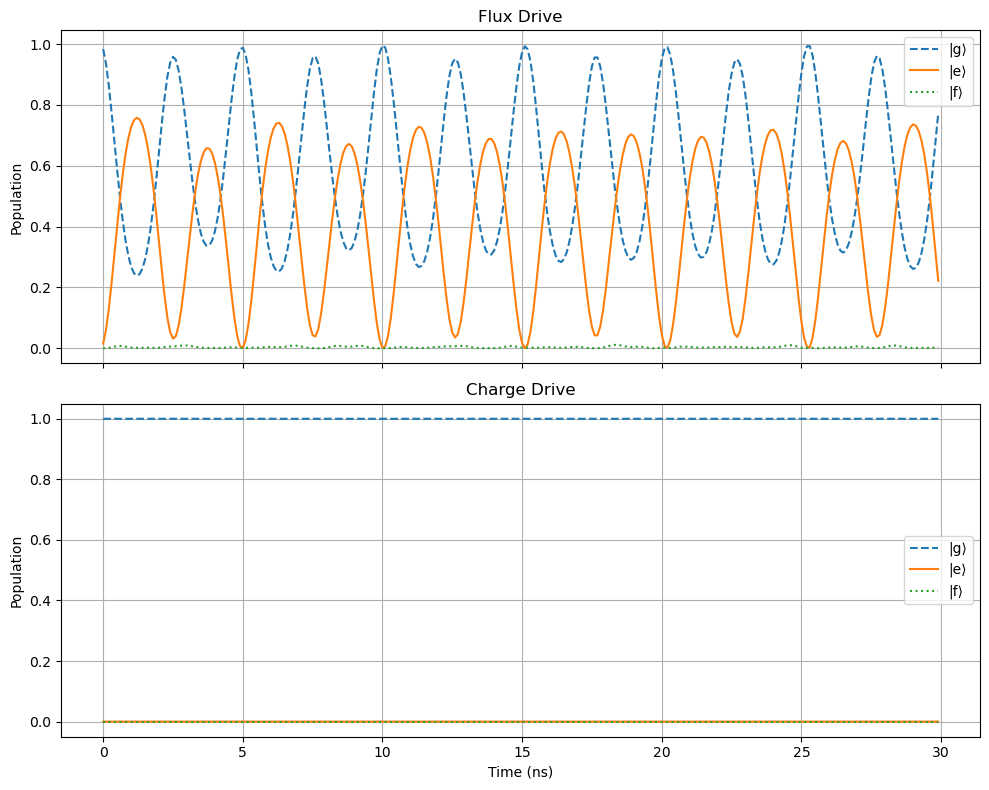

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, expm

# --- Parameters ---
EC = 1.0
EJ = 6.0
EL = 1.0
phi_ext_dc = 0.5
phi_amp = 0.5
n_amp = 0.05
t_pulse = 30
dt = 0.1
times = np.arange(0, t_pulse, dt)

# --- Discretize phase space ---
num_pts = 200
phi_min, phi_max = -10 * np.pi, 10 * np.pi
phi_vals = np.linspace(phi_min, phi_max, num_pts)
dphi = phi_vals[1] - phi_vals[0]

# --- Operators ---
T = -4 * EC * (
    -2 * np.eye(num_pts) +
    np.eye(num_pts, k=1) +
    np.eye(num_pts, k=-1)
) / dphi**2
phi_op = np.diag(phi_vals)

# Hermitian derivative for charge operator n = -i d/dphi
off_diag = np.ones(num_pts - 1)
deriv_matrix = (
    np.diag(-off_diag, -1) +
    np.diag(off_diag, 1)
) / (2 * dphi)
n_op = -1j * deriv_matrix

# Static Hamiltonian
V_static = -EJ * np.cos(phi_vals) + 0.5 * EL * (phi_vals - 2 * np.pi * phi_ext_dc)**2
H0 = T + np.diag(V_static)
evals, evecs = eigh(H0)
psi_0 = evecs[:, 0]
excited = evecs[:, 1]
level_2 = evecs[:, 2]
f_ge = evals[1] - evals[0]

# --- Drive envelope and waveform ---
def envelope(t):
    # return np.sin(np.pi * t / t_pulse)**2 if 0 <= t <= t_pulse else 0
    return 1

def drive_cos(t, amp, freq):
    return amp * envelope(t) * np.cos(2 * np.pi * freq * t)

# --- Time evolution: helper ---
def simulate_drive(H0, drive_op, amp, freq):
    psi_t = psi_0.copy()
    pop_g, pop_e, pop_f = [], [], []
    for t in times:
        drive_t = drive_cos(t, amp, freq)
        H_t = H0 + drive_t * drive_op
        U = expm(-1j * H_t * dt)
        psi_t = U @ psi_t
        psi_t /= np.linalg.norm(psi_t)
        pop_g.append(np.abs(np.vdot(psi_0, psi_t))**2)
        pop_e.append(np.abs(np.vdot(excited, psi_t))**2)
        pop_f.append(np.abs(np.vdot(level_2, psi_t))**2)
    return pop_g, pop_e, pop_f

# --- Simulate Flux and Charge Drives ---
pop_g_flux, pop_e_flux, pop_f_flux = simulate_drive(H0, -EL * phi_op, phi_amp, f_ge)
pop_g_charge, pop_e_charge, pop_f_charge = simulate_drive(H0, n_op, n_amp, f_ge)

# --- Plot all populations ---
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Flux Drive
axs[0].plot(times, pop_g_flux, label="|g⟩", linestyle='--')
axs[0].plot(times, pop_e_flux, label="|e⟩")
axs[0].plot(times, pop_f_flux, label="|f⟩", linestyle=':')
axs[0].set_ylabel("Population")
axs[0].set_title("Flux Drive")
axs[0].legend()
axs[0].grid(True)

# Charge Drive
axs[1].plot(times, pop_g_charge, label="|g⟩", linestyle='--')
axs[1].plot(times, pop_e_charge, label="|e⟩")
axs[1].plot(times, pop_f_charge, label="|f⟩", linestyle=':')
axs[1].set_xlabel("Time (ns)")
axs[1].set_ylabel("Population")
axs[1].set_title("Charge Drive")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


Comparing this method and sesolve



In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, expm
from qutip import *

# --- Parameters ---
EC = 1.0
EJ = 6.0
EL = 1.0
phi_ext_dc = 0.5
drive_amp = 0.1
t_pulse = 20
dt = 0.1
times = np.arange(0, t_pulse, dt)

# --- Discretize phase space ---
num_pts = 100
phi_min, phi_max = -6 * np.pi, 6 * np.pi
phi_vals = np.linspace(phi_min, phi_max, num_pts)
dphi = phi_vals[1] - phi_vals[0]

# --- Operators in phase basis ---
T = -4 * EC * (
    -2 * np.eye(num_pts) +
    np.eye(num_pts, k=1) +
    np.eye(num_pts, k=-1)
) / dphi**2

V = -EJ * np.cos(phi_vals) + 0.5 * EL * (phi_vals - 2 * np.pi * phi_ext_dc)**2
H0 = T + np.diag(V)

# Charge operator n = -i d/dphi
off_diag = np.ones(num_pts - 1)
n_op_mat = -1j * (
    np.diag(-off_diag, -1) + np.diag(off_diag, 1)
) / (2 * dphi)

# Diagonalize H0
evals, evecs = eigh(H0)
psi_0 = evecs[:, 0]
psi_1 = evecs[:, 1]

# --- Manual evolution with expm ---
def envelope(t):
    return np.sin(np.pi * t / t_pulse)**2 if 0 <= t <= t_pulse else 0

pop_manual = []
psi_t = psi_0.copy()

for t in times:
    Ht = H0 + drive_amp * envelope(t) * n_op_mat
    U = expm(-1j * Ht * dt)
    psi_t = U @ psi_t
    psi_t /= np.linalg.norm(psi_t)
    pop_manual.append(np.abs(np.vdot(psi_1, psi_t))**2)

# --- Qutip version ---
# Convert numpy arrays to Qobj
H0_q = Qobj(H0)
n_op_q = Qobj(n_op_mat)
psi0_q = Qobj(psi_0)

# Time-dependent Hamiltonian
H_td = [H0_q, [n_op_q, lambda t, args: drive_amp * envelope(t)]]


from qutip import Qobj

# Create the projection operator onto the excited state
psi_1_q = Qobj(evecs[:, 1])
proj_1 = psi_1_q * psi_1_q.dag()

# Use this as the expectation operator
result = sesolve(H_td, psi0_q, times, [proj_1])
pop_qutip = result.expect[0]  # This is |⟨psi_1|psi(t)⟩|^2
# Solve using QuTiP
result = sesolve(H_td, psi0_q, times, [evecs[:, 1]])  # project to psi_1

# Manually calculate projection to excited state
pop_qutip = [np.abs((Qobj(evecs[:, 1]).dag() * state)[0, 0])**2 for state in result.states]

# --- Plot comparison ---
plt.figure(figsize=(8, 4))
plt.plot(times, pop_manual, label="Manual Evolution", lw=2)
plt.plot(times, pop_qutip, '--', label="QuTiP sesolve", lw=2)
plt.xlabel("Time (ns)")
plt.ylabel(r"$|\langle e|\psi(t)\rangle|^2$")
plt.title("Charge Drive: Manual vs QuTiP sesolve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


TypeError: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.16703241e-19,
        1.39014977e-18,  8.55711223e-18,  5.07617980e-17,  2.91627071e-16,
        1.63019631e-15,  8.89922856e-15,  4.75318252e-14,  2.48321253e-13,
        1.26570496e-12,  6.26517115e-12,  2.99296745e-11,  1.36991628e-10,
        5.96297254e-10,  2.45151146e-09,  9.46889279e-09,  3.42612272e-08,
        1.16163014e-07,  3.70494950e-07,  1.11983226e-06,  3.24003225e-06,
        9.07478974e-06,  2.48605589e-05,  6.71192466e-05,  1.79174984e-04,
        4.72197656e-04,  1.22087044e-03,  3.06523874e-03,  7.37473781e-03,
        1.67457377e-02,  3.53134943e-02,  6.80683091e-02,  1.18188330e-01,
        1.82619322e-01,  2.48947785e-01,  2.98140207e-01,  3.13880493e-01,
        2.92044209e-01,  2.42242368e-01,  1.80699676e-01,  1.21221779e-01,
        7.04891567e-02,  2.83939151e-02, -9.33749153e-03, -4.85647712e-02,
       -9.46371896e-02, -1.50102898e-01, -2.11934955e-01, -2.69663001e-01,
       -3.07327404e-01, -3.10805025e-01, -2.76903463e-01, -2.16666689e-01,
       -1.49165504e-01, -9.09478328e-02, -4.96292056e-02, -2.45684169e-02,
       -1.12046878e-02, -4.78429863e-03, -1.94310162e-03, -7.61511441e-04,
       -2.91422679e-04, -1.09816540e-04, -4.09103864e-05, -1.50533510e-05,
       -5.44071896e-06, -1.91390721e-06, -6.48087018e-07, -2.08966427e-07,
       -6.35912318e-08, -1.81603403e-08, -4.85693424e-09, -1.21818323e-09,
       -2.87741939e-10, -6.44057846e-11, -1.37605727e-11, -2.82734227e-12,
       -5.62494436e-13, -1.08954735e-13, -2.06223356e-14, -3.81954624e-15,
       -6.91679527e-16, -1.22117580e-16, -2.09161285e-17, -3.37443582e-18]) has unsupported type <class 'numpy.ndarray'>.